In [159]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import spatial_maps as sm
import scipy

from tqdm import tqdm
from models import FFGC, RNNGC
from plotting_functions import *
from dataset import DatasetMaker

import umap.umap_ as umap
import plotly.express as px
from sklearn.decomposition import PCA

## RNN

In [160]:
## Training parameters
train_steps = 50000
timesteps = 10
bs = 64 # batch size

# Model parameters
ng = 256 # no. of recurrent units
# alpha = 0.88

In [161]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNGC(ng = ng)
model = model.load("./saved-models/RNNGC_49999.pkl")

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

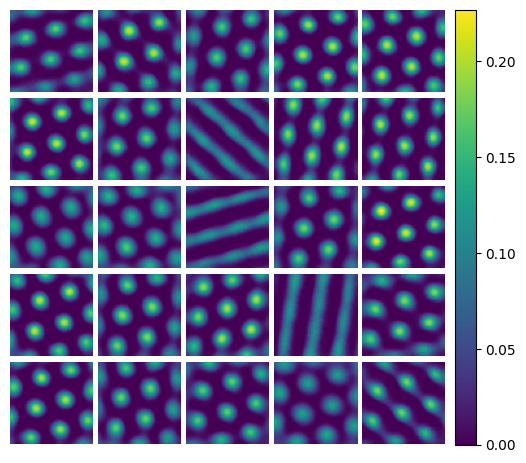

In [162]:
dataset = DatasetMaker()
rt, vt = dataset.generate_data(50000, 10)

rt = rt.to(device)
vt = vt.to(device)

bins = 64

g = model((rt[:,0], vt)).cpu().detach().numpy() # double check that states are alright
g_ratemaps = scipy.stats.binned_statistic_2d(rt[...,0].ravel().cpu().numpy(), rt[...,1].ravel().cpu().numpy(), g.reshape(-1, g.shape[-1]).T, bins = bins)[0]
multiimshow(g_ratemaps[:25], figsize=(5,5));

In [163]:
g_ratemaps.shape

(256, 64, 64)

In [164]:
activity = g_ratemaps.reshape(g_ratemaps.shape[0], -1)
activity.shape

# activity = activity[:128]
activity.shape

(256, 4096)

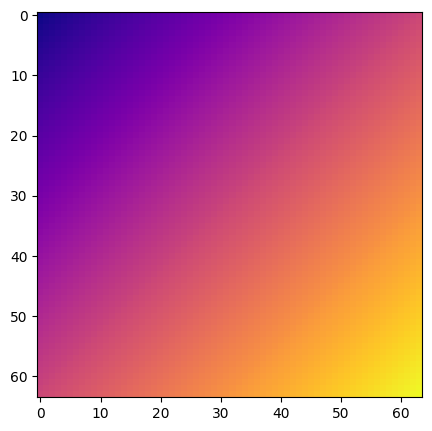

In [165]:
xcol = np.arange(0,int(np.sqrt(activity.shape[-1])))
ycol = np.arange(0,int(np.sqrt(activity.shape[-1])))

xx, yy = np.meshgrid(xcol,ycol)
cols = xx + yy
cols_flat = cols.flatten()

# Plot colormap of cols
fig = plt.figure(figsize=(5,5))
plt.imshow(cols, cmap='plasma')
plt.show()

In [166]:
n_neighbors = 2000
n_components = 3
plot = True

reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components)
reducer.fit(activity.T)
embedding = reducer.transform(activity.T)
print(embedding.shape)
if plot and n_components==2:
    plt.scatter(embedding[:,0],embedding[:,1],s=10)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the activity of the grid cells', fontsize=12)
    plt.show()
elif plot and n_components==3:
    fig = px.scatter_3d(embedding, x=0, y=1, z=2,opacity=0.4,color=cols_flat)
    fig.show()

(4096, 3)


In [167]:
reducer = PCA(n_components=n_components)
reducer.fit(activity.T)
embedding = reducer.transform(activity.T)
print(embedding.shape)
# Explained variance
print(f"Explained variance for PCA with {n_components} components: {100*np.sum(reducer.explained_variance_ratio_):.3f} %")
if plot and n_components==2:
    plt.scatter(embedding[:,0],embedding[:,1],s=10)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('PCA projection of the activity of the grid cells', fontsize=12)
    plt.show()
elif plot and n_components==3:
    fig = px.scatter_3d(embedding, x=0, y=1, z=2,opacity=0.4,color=cols_flat)
    fig.show()

(4096, 3)
Explained variance for PCA with 3 components: 48.562 %


## FF

In [170]:
model = FFGC()
model = model.load("./saved-models/FFGC_200000.pkl")

model.to(device)
pass

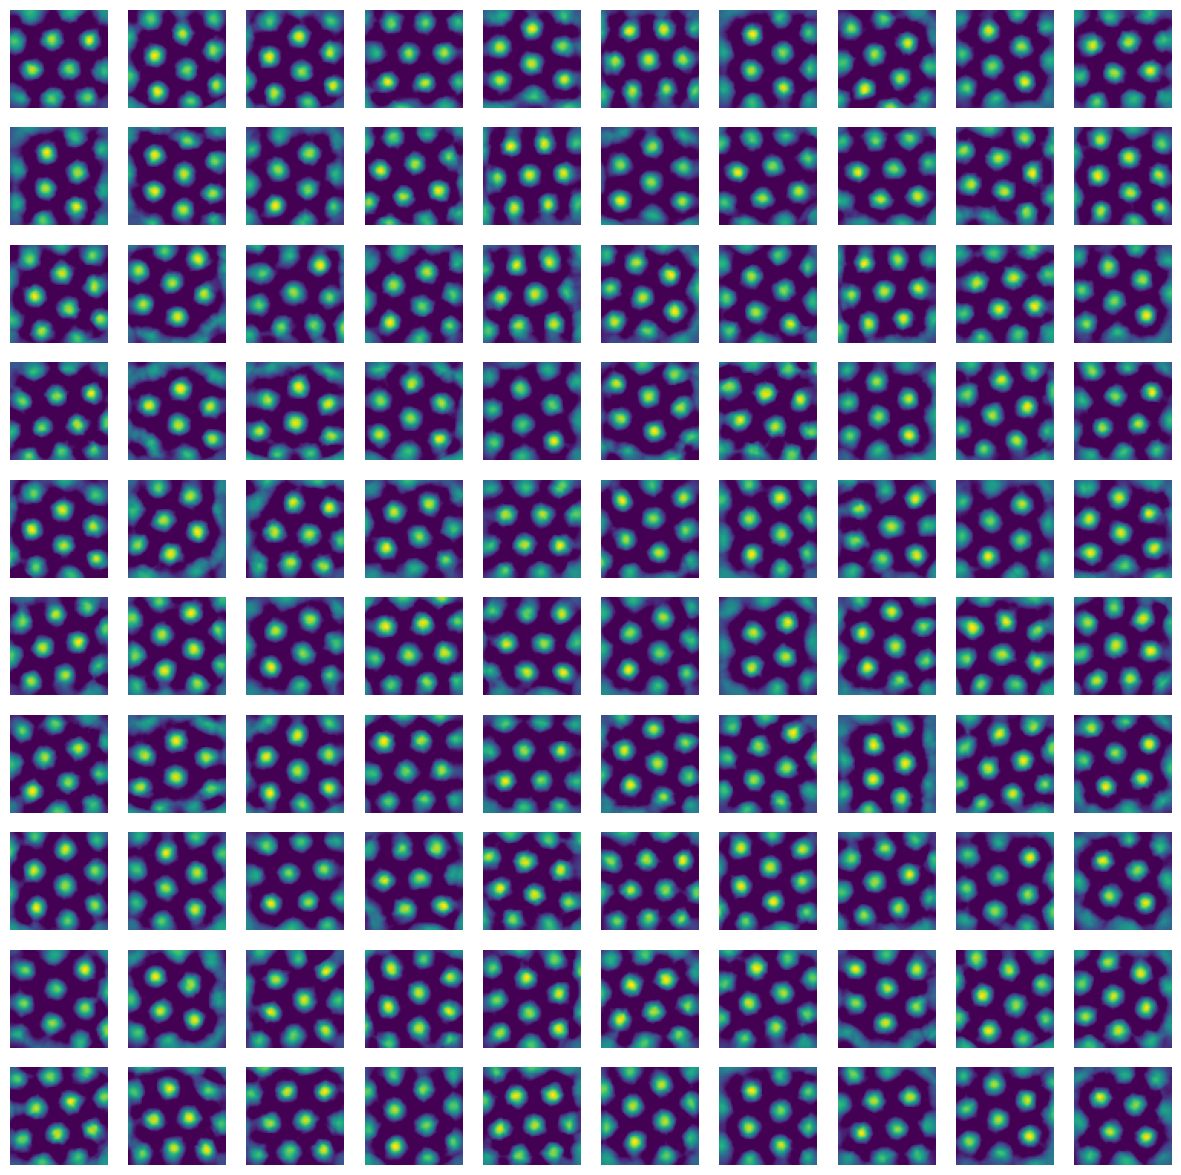

In [171]:
# evaluate on 64x64 grid
bins = 64
x = np.linspace(-1, 1, bins)*2*np.pi
y = np.linspace(-1, 1, bins)*2*np.pi
xx, yy = np.meshgrid(x,y)
r = np.stack([xx.ravel(), yy.ravel()], axis = -1)
gs = model(torch.tensor(r.astype("float32"),device = device))
gs = gs.detach().cpu().numpy()

ns = 10 # ns x ns grid of unit ratemaps
count = 0
fig ,ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(gs[...,count].reshape(bins, bins))
        ax[i,j].axis("off")
        count += 1

In [172]:
gs = gs.T.reshape(-1,bins,bins)
grid_score = np.array([sm.gridness(gs[i]) for i in range(len(gs))])

In [173]:
acorrs = np.array([sm.autocorrelation(g) for g in gs])
acorrs = acorrs[grid_score > 0.5]
gs = gs[grid_score > 0.5]

In [174]:
peaks = [sm.find_peaks(acorr) for acorr in acorrs]
spacings = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[0] for peak in peaks])
orientations = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[1] for peak in peaks])

(array([20.,  3.,  2.,  5.,  1.,  3., 20., 19., 45., 15., 15., 14.,  2.,
        10.,  5., 15., 11.,  9., 17.,  7.]),
 array([0.        , 0.05230003, 0.10460006, 0.15690008, 0.20920011,
        0.26150014, 0.31380017, 0.36610019, 0.41840022, 0.47070025,
        0.52300028, 0.57530031, 0.62760033, 0.67990036, 0.73220039,
        0.78450042, 0.83680044, 0.88910047, 0.9414005 , 0.99370053,
        1.04600056]),
 <BarContainer object of 20 artists>)

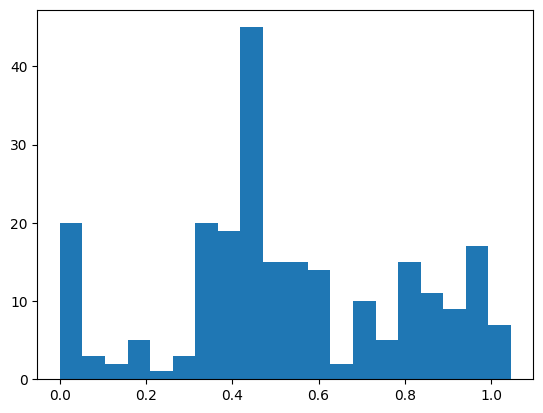

In [175]:
plt.hist(orientations, bins = 20)
# plt.show()

In [176]:
gs_big_o = gs[orientations > 0.45]
gs_mid_o = gs[(orientations > 0.35) & (orientations < 0.55)]
gs_low_o = gs[orientations < 0.35]

activity_low_o = gs_low_o.reshape(gs_low_o.shape[0], -1)
activity_mid_o = gs_mid_o.reshape(gs_mid_o.shape[0], -1)
activity_big_o = gs_big_o.reshape(gs_big_o.shape[0], -1)
activity_mid_o.shape

(95, 4096)

In [179]:
gs_mid_o.T.shape

(64, 64, 95)

IndexError: index 95 is out of bounds for axis 2 with size 95

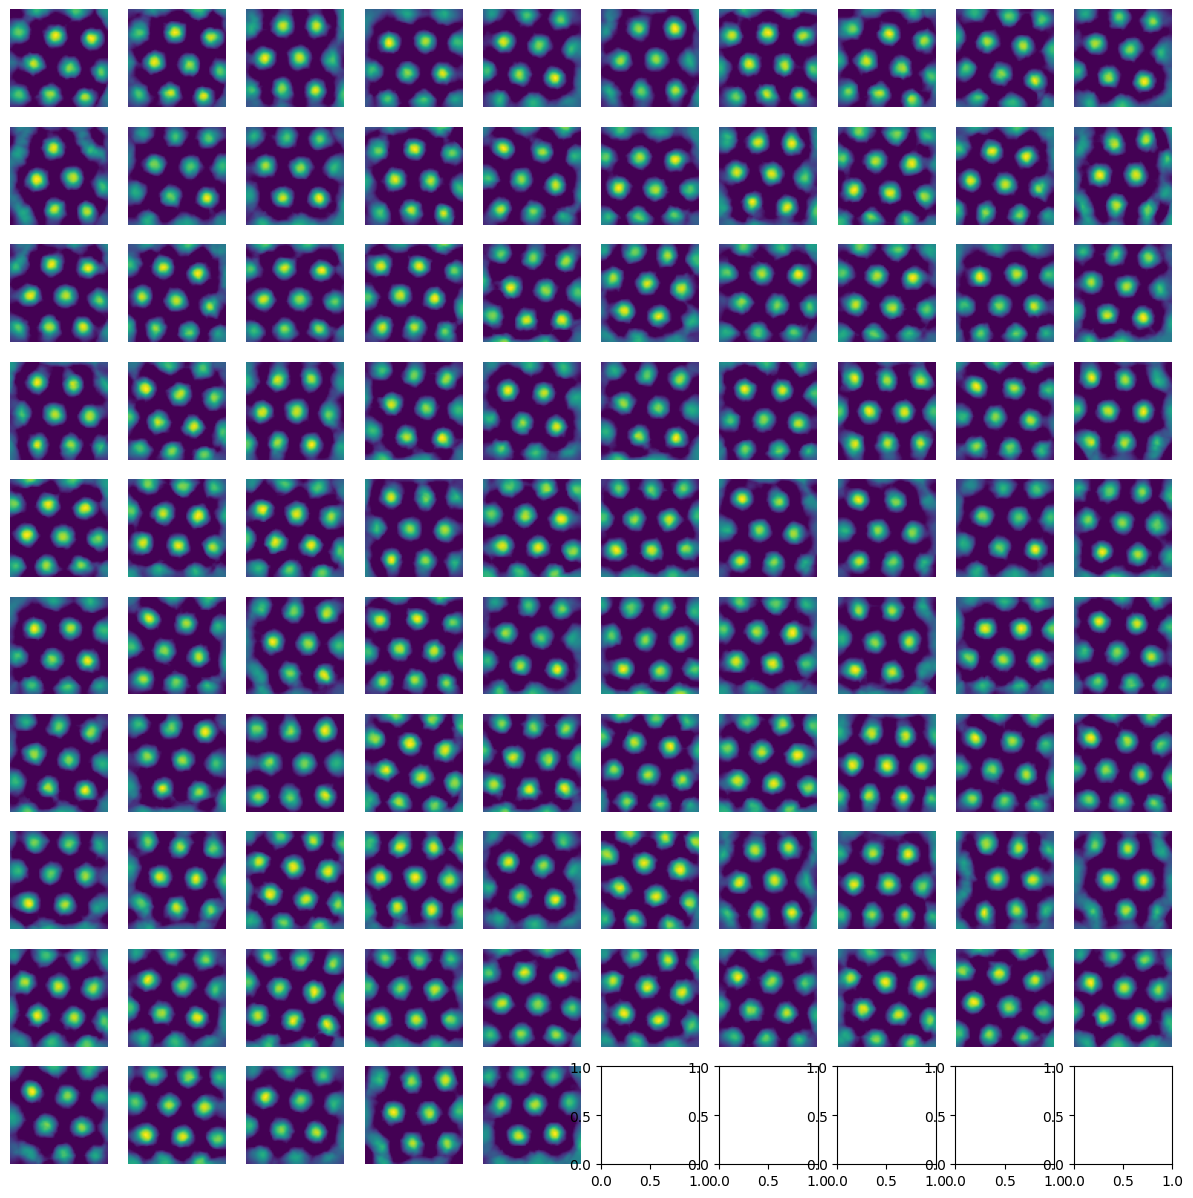

In [180]:
ns = 10 # ns x ns grid of unit ratemaps
count = 0
fig ,ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(gs_mid_o.T[...,count].reshape(bins, bins))
        ax[i,j].axis("off")
        count += 1

In [185]:
n_neighbors = 2000
n_components = 3
plot = True

reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components)
reducer.fit(activity_mid_o.T)
embedding = reducer.transform(activity_mid_o.T)
print(embedding.shape)
if plot and n_components==2:
    plt.scatter(embedding[:,0],embedding[:,1],s=10)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the activity of the grid cells', fontsize=12)
    plt.show()
elif plot and n_components==3:
    fig = px.scatter_3d(embedding, x=0, y=1, z=2,opacity=0.4,color=cols_flat)
    fig.show()

(4096, 3)


In [186]:
reducer = PCA(n_components=n_components)
reducer.fit(activity_mid_o.T)
embedding = reducer.transform(activity_mid_o.T)
print(embedding.shape)
# Explained variance
print(f"Explained variance for PCA with {n_components} components: {100*np.sum(reducer.explained_variance_ratio_):.3f} %")
if plot and n_components==2:
    plt.scatter(embedding[:,0],embedding[:,1],s=10)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('PCA projection of the activity of the grid cells', fontsize=12)
    plt.show()
elif plot and n_components==3:
    fig = px.scatter_3d(embedding, x=0, y=1, z=2,opacity=0.4,color=cols_flat)
    fig.show()

(4096, 3)
Explained variance for PCA with 3 components: 48.141 %
